In [1]:
import numpy as np
import fastscapelib_fortran as fs
import lsdtopytools as lsd
import numba as nb
from matplotlib import pyplot as plt
%matplotlib inline

@nb.njit()
def check_stack(stack):
    checker = np.zeros(stack.shape, dtype = np.int32)
    incr = 0
    for i in stack:
        checker[i] = incr
        incr +=1
    return checker

@nb.njit()
def try_identify_pits(receivers, elev, stack):
    pits = []
    recapit = []
    for i in range(receivers.shape[0]):
        ispit = False
        for j in range(receivers.shape[1]):
            if(receivers[i,j] == -1 or ispit == True or receivers[i,j] == i):
                continue
                
            if(elev[i]<elev[receivers[i,j] ]):
                pits.append(i)
                recapit.append(receivers[i,j])
                ispit = True
                
    return np.array(pits),np.array(recapit)

@nb.njit()
def try_identify_pits_single(receivers, elev, stack):
    pits = []
    recapit = []
    for i in range(receivers.shape[0]):

        if(receivers[i] == -1 or receivers[i] == i):
            continue

        if(elev[i]<elev[receivers[i]]):
            pits.append(i)
            recapit.append(receivers[i])


    return np.array(pits),np.array(recapit)
            
@nb.njit()
def get_delta_elev(receivers, elev, stack):
    pits = []
    for i in range(receivers.shape[0]):
        ispit = False
        for j in range(receivers.shape[1]):
            if(receivers[i,j] == -1 or ispit == True):
                continue
                
            if(elev[i]<elev[receivers[i,j]]):
                pits.append(i)
                ispit = True
                
    return np.array(pits)
            
            

In [2]:
#raster name putna_50_NDF
raster = lsd.raster_loader.load_raster("putna_50_NDF.tif")

In [3]:
fs.fastscape_init()
fs.fastscape_set_nx_ny(raster["ncols"],raster["nrows"])
fs.fastscape_setup()
fs.fastscape_set_xl_yl(raster["x_max"] - raster["x_min"],raster["y_max"] - raster["y_min"] )
fstctx = fs.fastscapecontext

In [4]:
fstctx.p = 3
fstctx.h = raster["array"].astype(np.float64).ravel()
# fs.fastscape_init_h(raster["array"].astype(np.float64).ravel())

fstctx.kf = np.ones_like(fstctx.h) * 1e-3
fstctx.kfsed = 1e-3
fstctx.m = 0.45
fstctx.n = 1.
fstctx.kd = np.ones_like(fstctx.h) * 1e-3
fstctx.kdsed = 1e-3
fstctx.g1 = 1.0
fstctx.g2 = 1.0
fstctx.ibc = 1111
fs.fastscape_set_dt(1000)


# fs.find_mult_rec() 

fs.flowrouting()

bc = 1000

stack = fstctx.mstack.astype('int') - 1
nb_receivers = fstctx.mnrec.astype('int')
receivers = fstctx.mrec.astype('int').transpose() - 1
lengths = fstctx.mlrec.transpose()
weights = fstctx.mwrec.transpose()

sstack = fstctx.stack.astype('int') - 1
sreceivers = fstctx.rec.astype('int') - 1

[-1 -1 -1 -1 -1 -1 -1 -1]
(1420020,)


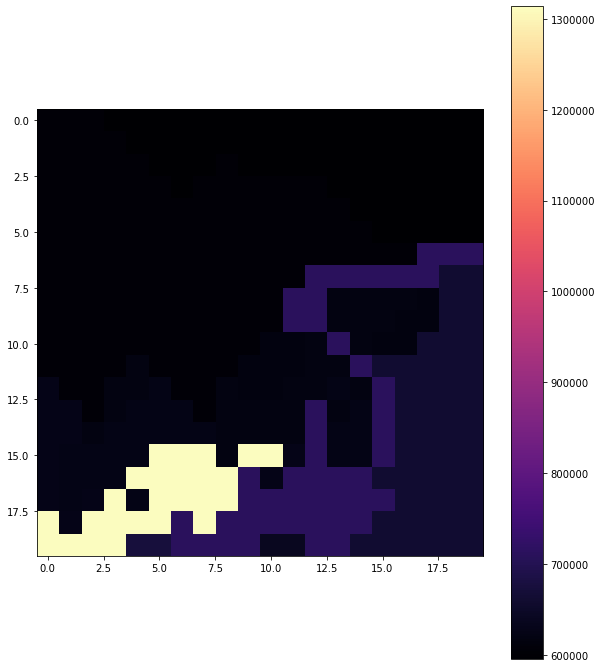

In [16]:
# fstctx.mstack.astype("int")
checker = check_stack(stack)
checker = checker.reshape(raster["nrows"],raster["ncols"])
pits, recapit = try_identify_pits(receivers, raster["array"].astype(np.float32).ravel(), stack)
# pits, recapit = try_identify_pits_single(sreceivers, raster["array"].astype(np.float32).ravel(), sstack)

fig,ax = plt.subplots(figsize = (10,12))
cb = ax.imshow(raster["array"][500: 520, 695:715 ], cmap = "gray", vmin = 300, vmax = 400)
cb =ax.imshow(checker[500: 520,695:715 ], alpha=1, cmap = "magma")
# cb =ax.imshow(nb_receivers.reshape(raster["nrows"],raster["ncols"]), alpha=1, cmap = "magma")
colspit = pits % raster["ncols"]
rowspit = ((pits - colspit)/ raster["ncols"]).astype(np.int32)

rcolspit = recapit % raster["ncols"]
rrowspit = ((recapit - rcolspit)/ raster["ncols"]).astype(np.int32)

# ax.scatter(colspit, rowspit, lw = 0, c = "yellow")
# ax.scatter(rcolspit, rrowspit, lw = 0, c = "green")

# ax.set_xlim(695,715)
# ax.set_ylim(520, 500)

print(receivers[0])
print(stack.shape)

plt.colorbar(cb)

In [18]:
cols = stack % raster["ncols"]
rows = ((stack - cols)/ raster["ncols"]).astype(np.int32)
import lsdtopytools as lsd
mydem = lsd.LSDDEM(file_name ="putna_50_NDF.tif", already_preprocessed = True )
X,Y = mydem.cppdem.query_xy_from_rowcol(rows,cols)
import pandas as pd
pd.DataFrame({"incr": checker.ravel(), "X": X, "Y":Y}).to_csv("checker.csv", index = False)

Loading the raster from file: ./putna_50_NDF.tif
LOADING TOOK 2.1628315448760986
I am recasting your nodata values to -9999 (standard LSDTT)
PREPROC TOOK 0.0016355514526367188
Alright, let me summon control upon the c++ code ...
Got it.
INGESTINGINTO CPP TOOK 0.006393909454345703
TELLINGCPP IT IS PP TOOK 0.002369403839111328
FINALISATION TOOK 0.006168365478515625
lsdtopytools is now ready to roll!


In [ ]:
bite =  np.zeros(fstctx.nn)
bc =  np.zeros(fstctx.nn)

dx = fstctx.xl/(fstctx.nx - 1)
dy = fstctx.yl/(fstctx.ny - 1)
i1 = np.int32(0)
i2 = np.int32(0)
j1 = np.int32(0)
j2 = np.int32(0)
xcyclic = np.bool(0)
ycyclic = np.bool(0)

fs.set_bc(fstctx.ibc, fstctx.nx, fstctx.ny) #, i1, i2, j1, j2, bc, xcyclic, ycyclic)
fs.find_receiver(fstctx.h,fstctx.nx,fstctx.ny,dx,dy,i1,i2,j1,j2,xcyclic, ycyclic)


In [ ]:
fs.fastscape_destroy()